In [4]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2021-11-19 11:10:08--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.20.126
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2021-11-19 11:10:08--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?nq9KYfHPI7zqrWkXMKsYVu6kCOeEk2WYNIoVb3hDKZ_YN3GOmkWQAZL0J2Gc2y2yd5J106SppPZpWbdN7jrjJCWNmEepeuFjRPgJZ9s5d6f1U

In [5]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 66 kB 4.8 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627454 sha256=004c3e78b344902dd1da2366a468ddd38585be9e44406b8583db50fb4cd3a756
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=5a5cb6be270d3fbe618d4c7409448bfacb3bdbbdf28e097bb28c10693cce75f6
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [6]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [7]:
!nvidia-smi

Fri Nov 19 11:15:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import pycuda.autoinit
from pycuda import driver as cuda, compiler, tools
tools.make_default_context().get_device().name()

'Tesla K80'

In [9]:
# Среднее время сумирования на GPU
avgTimeGPU = list()
# Среднее время сумирования на CPU
avgTimeCPU = list()
# Среднее время сумирования с помощью средств библиотеки numpy
avgTimeNumpy = list()
# Размерности, получающиеся с помощью python генератора от 1024 до 1048576
sizes = np.array([2**i for i in range(10, 21)])  
# Количество итераций включая холодный старт (без него количество итераций 10)
iterCount = 10
# Размер блока
BLOCK_SIZE = 512

In [10]:
sumVector = """
__device__ void warpReduce(volatile int* shared_memory, int tid) {
	shared_memory[tid] += shared_memory[tid + 32];
	shared_memory[tid] += shared_memory[tid + 16];
	shared_memory[tid] += shared_memory[tid + 8];
	shared_memory[tid] += shared_memory[tid + 4];
	shared_memory[tid] += shared_memory[tid + 2];
	shared_memory[tid] += shared_memory[tid + 1];
}

// Функция ядра
// Выполнение суммирования элементов массива на GPU
__global__ void sumVectorKernel(int* vec, int* res) {
	// Выделение памяти 
	__shared__ int shared_memory[2048];
	// Выполнение расчета идентификатора потока
	int tid = threadIdx.x;
	// Загрузка элементов
	// Расчет масштабируемого индекса
	int i = blockIdx.x * (blockDim.x * 2) + tid;
	// Сохранение первой подсчитанной частичной суммы, помимо элементов
	shared_memory[tid] = vec[i] + vec[i + blockDim.x];
	__syncthreads();
  // Перед началом цикла разделим блок на две части, после чего каждую итерацию,
  // так же делим его на две части
	for (int s = blockDim.x / 2; s > 32; s >>= 1) {
		if (tid < s) {
			shared_memory[tid] += shared_memory[tid + s];
		}
		__syncthreads();
	}
	if (tid < 32) {
		warpReduce(shared_memory, tid);
	}
	// Поток 0 для определенного блока результат будет писать в основную память
	// Результат индексируется этим блоком
	if (tid == 0) {
		res[blockIdx.x] = shared_memory[0];
	}
}
"""

In [11]:
def launch():
  """
  -> Функция для запуска экспериментов
  """
  for size in sizes:
    # Создание данных на хосте
    hostVec = np.ones(size, dtype=np.int32)
    hostResult = np.zeros(size, dtype=np.int32)

    # Выделение памяти на GPU
    deviceVec = cuda.mem_alloc(hostVec.nbytes)
    deviceResult = cuda.mem_alloc(hostResult.nbytes)

    # Вычислим необходимое количество блоков и количество нитей в этих блоках
    # 1-мерный вектор (массив)
    bdim = (BLOCK_SIZE, 1, 1)
    # Нити WARNING WARNING WARNING (BLOCK_SIZE * 2)
    gdim = int((size + BLOCK_SIZE - 1) / (BLOCK_SIZE * 2))

    # Массивы с временами на соответствующем устройстве для вычисления среднего 
    timesNumpyVecsum = list()
    timesPythonVecsum = list()
    timesGPUVecsum = list()
    pythonSum = 0
    numpySum = 0

    for _ in range(iterCount):
      
      # Суммирование вектора с помощью стандартных средств языка python
      startTime = time.time()
      pythonSum = sum(hostVec)
      endTime = time.time()
      timesPythonVecsum.append(endTime - startTime)

      # Суммирование вектора с помощью библиотеки numpy
      startTime = time.time()
      numpySum = np.sum(hostVec)
      endTime = time.time()
      timesNumpyVecsum.append(endTime - startTime)

      # Суммирование вектора с помощью GPU (включая время на пересылку данных)
      startTime = time.time()
      # Отправляем данные на GPU deviceMemVec
      cuda.memcpy_htod(deviceVec, hostVec)
      cuda.memcpy_htod(deviceResult, hostResult)
      # Компилируем ядро
      buildKernel = compiler.SourceModule(sumVector)
      # Загружаем функцию, которая выполняет расчет суммы вектора
      sumVecFunc = buildKernel.get_function("sumVectorKernel")

      sumVecFunc(deviceVec, deviceResult, block=(BLOCK_SIZE, 1, 1), grid=(gdim, 1))
      sumVecFunc(deviceResult, deviceResult, block=(BLOCK_SIZE, 1, 1), grid=(1, 1))
      cuda.memcpy_dtoh(hostResult, deviceResult)
      endTime = time.time()
      timesGPUVecsum.append(endTime - startTime)

    # Вычисление среднего значения времени
    avgTimeGPU.append(np.mean(timesGPUVecsum[1:]))
    avgTimeCPU.append(np.mean(timesPythonVecsum[1:]))
    avgTimeNumpy.append(np.mean(timesNumpyVecsum[1:]))
    
    print(f"Size = {size}; Grid = {gdim}.\t Numpy: {numpySum}\tPython: {pythonSum}\tGPU: {hostResult[0]}\t")

  print(f"GPU = {avgTimeGPU}")
  print(f"Python = {avgTimeCPU}")
  print(f"Numpy = {avgTimeNumpy}")

In [12]:
launch()

Size = 1024; Grid = 1.	 Numpy: 1024	Python: 1024	GPU: 1024	
Size = 2048; Grid = 2.	 Numpy: 2048	Python: 2048	GPU: 2048	
Size = 4096; Grid = 4.	 Numpy: 4096	Python: 4096	GPU: 4096	
Size = 8192; Grid = 8.	 Numpy: 8192	Python: 8192	GPU: 8192	
Size = 16384; Grid = 16.	 Numpy: 16384	Python: 16384	GPU: 16384	
Size = 32768; Grid = 32.	 Numpy: 32768	Python: 32768	GPU: 32768	
Size = 65536; Grid = 64.	 Numpy: 65536	Python: 65536	GPU: 65536	
Size = 131072; Grid = 128.	 Numpy: 131072	Python: 131072	GPU: 131072	
Size = 262144; Grid = 256.	 Numpy: 262144	Python: 262144	GPU: 262144	
Size = 524288; Grid = 512.	 Numpy: 524288	Python: 524288	GPU: 524288	
Size = 1048576; Grid = 1024.	 Numpy: 1048576	Python: 1048576	GPU: 1048576	
GPU = [0.0008183320363362631, 0.0008270740509033203, 0.0008154180314805773, 0.0007596545749240451, 0.0009538067711724176, 0.001205338372124566, 0.0010212262471516926, 0.0012367566426595051, 0.0023359722561306423, 0.0027189519670274523, 0.003586186303032769]
Python = [0.0002891752

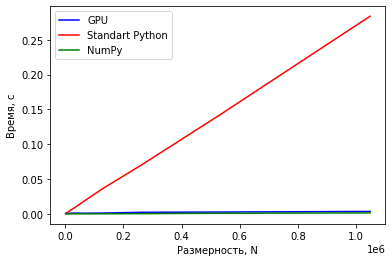

In [13]:
plt.plot(sizes, avgTimeGPU, color="blue", label="GPU")
plt.plot(sizes, avgTimeCPU, color="red", label="Standart Python")
plt.plot(sizes, avgTimeNumpy, color="green", label="NumPy")
plt.xlabel("Размерность, N")
plt.ylabel("Время, с")
plt.legend()
plt.show()

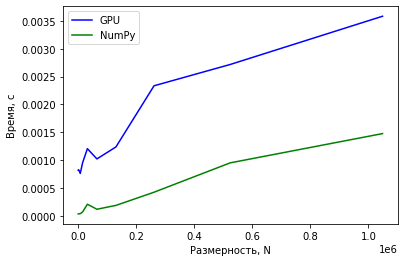

In [14]:
plt.plot(sizes, avgTimeGPU, color="blue", label="GPU")
plt.plot(sizes, avgTimeNumpy, color="green", label="NumPy")
plt.xlabel("Размерность, N")
plt.ylabel("Время, с")
plt.legend()
plt.show()

Text(0.5, 0, 'Размерность, N')

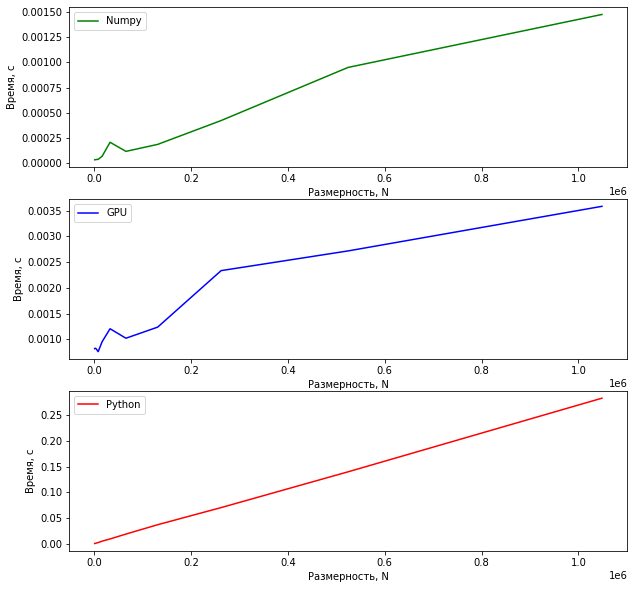

In [15]:
# Одиночные графики
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(sizes, avgTimeNumpy, color="green", label="Numpy")
axes[0].legend()
axes[0].set_ylabel("Время, с")
axes[0].set_xlabel("Размерность, N")
axes[1].plot(sizes, avgTimeGPU, color="blue", label="GPU")
axes[1].legend()
axes[1].set_ylabel("Время, с")
axes[1].set_xlabel("Размерность, N")
axes[2].plot(sizes, avgTimeCPU, color="red", label="Python")
axes[2].legend()
axes[2].set_ylabel("Время, с")
axes[2].set_xlabel("Размерность, N")

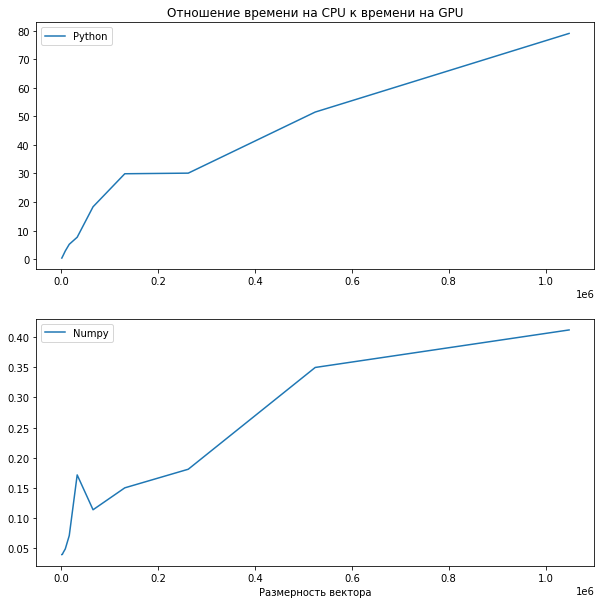

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(sizes, np.array(avgTimeCPU) / np.array(avgTimeGPU), label="Python")
axes[1].plot(sizes, np.array(avgTimeNumpy) / np.array(avgTimeGPU), label="Numpy")
axes[0].set_title("Отношение времени на CPU к времени на GPU")
axes[1].set_xlabel("Размерность вектора")
axes[0].legend()
axes[1].legend()

In [17]:
df = pd.DataFrame({"Numpy": avgTimeNumpy, "StandartPython": avgTimeCPU, "GPU": avgTimeGPU}, index=sizes)
df.to_excel("CPU and GPU.xlsx")
df

,Numpy,StandartPython,GPU
1024,0.000032,0.000289,0.000818
2048,0.000033,0.000580,0.000827
4096,0.000035,0.001136,0.000815
8192,0.000037,0.002155,0.000760
16384,0.000068,0.004938,0.000954
32768,0.000207,0.009226,0.001205
65536,0.000116,0.018715,0.001021
131072,0.000186,0.036982,0.001237
262144,0.000423,0.070349,0.002336
524288,0.000950,0.140097,0.002719
